[View in Colaboratory](https://colab.research.google.com/github/yylonly/GoogleCoLab/blob/master/4_ServeNet_1_BI_LTSM(1024)_(Glove200b_trainedEmbeddingLayer).ipynb)

## ServeNet-LTSM (Glove50b-trainedEmbeddingLayer)

In [0]:
!pkill -9 -f ipykernel_launcher

In [1]:
!/opt/bin/nvidia-smi

Mon May  7 20:49:09 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    29W / 149W |      1MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))


Gen RAM Free: 12.6 GB  I Proc size: 140.9 MB
GPU RAM Free: 11438MB | Used: 1MB | Util   0% | Total 11439MB


In [0]:
printm()

In [0]:
!kill -9 -1

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
import os
os.chdir("/content/drive/Colab Notebooks/")

In [3]:
!ls -l

total 14052
drwxr-xr-x 2 root root    4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root    4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root    4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root    4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root    4096 Mar  1 18:00 17.Face Recognition
-rw-r--r-- 1 root root    1191 May  6 10:15 1D-CNN-BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  6 10:15 1DCNN-BI-LTSM-glove50-top5.pdf
drwxr-xr-x 2 root root    4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root    4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root  715412 May  7 20:49 4.ServeNet-1-BI-LTSM(1024) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  764050 May  7 19:01 4.ServeNet-1-BI-LTSM(128) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  745997 May  7 20:31 4.ServeNet-1-BI-LTSM(512) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root 

In [4]:
#import plaidml.keras
#plaidml.keras.install_backend()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import h5py
import pandas as pd

#from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.models import load_model
from keras import metrics
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint
from keras.layers.wrappers import Bidirectional

np.random.seed(0)
%matplotlib inline

Using TensorFlow backend.


In [5]:
h5f = h5py.File('data/SplittedPaddedIndexedServiceDataset.h5','r') 
X_train = h5f['indexed_padded_Train_X'][:]
Y_train = h5f['Train_Y_one_hot'][:]
X_test = h5f['indexed_padded_Test_X'][:]
Y_test = h5f['Test_Y_one_hot'][:]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
h5f.close()

(8123, 110) (8123, 50)
(2061, 110) (2061, 50)


In [6]:
X_train[0]

array([192973,  54273, 270501, 294803, 286278, 121851, 360915, 363921,
       270193, 219115, 154323, 278439, 291761, 191811, 191143, 270193,
       133719, 142813, 388756, 306178, 104329, 142808, 374253, 357266,
       286278, 354433,  54718, 345909, 236860, 142838,  90548, 327482,
       357354, 209662, 374253,  43010, 111455,  91182, 156214,  58791,
       270501,  57488,  54718, 149979, 136170, 270927, 294049,  43010,
       332120, 186717,  69725,  57459, 151349,  86371, 191143, 219115,
        57840, 386474,  58997,  89857, 156216, 122453, 374163, 182908,
       199199, 113067, 360915, 111448, 156216, 386474,  58997, 357412,
       182158, 269798, 357266, 286278,  54718, 107110,  88126, 354433,
       151349, 219113, 360915, 191135, 388711, 357266, 325899, 268046,
       325776, 188836, 281890,  61645, 373469, 363840,  54718,  61640,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0], dtype=int32)

In [7]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [0]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.200d.txt')

In [0]:
# GRADED FUNCTION: pretrained_embedding_layer

def trainable_embedding_layer():
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [0]:
# GRADED FUNCTION: Emojify_V2

def ServeNet(input_shape):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = trainable_embedding_layer()
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices) 
     
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = Bidirectional(LSTM(1024, return_sequences=False))(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(50)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [0]:
maxLen = 110

In [13]:
model = ServeNet((maxLen, ))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 110)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 110, 200)          80000200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 2048)              10035200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                102450    
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
Total params: 90,137,850
Trainable params: 10,137,650
Non-trainable params: 80,000,200
_______________________________________________________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[metrics.categorical_accuracy, metrics.top_k_categorical_accuracy])

In [15]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 50, batch_size = 128)

Train on 8123 samples, validate on 2061 samples
Epoch 1/50
8123/8123 [==============================] - 70s 9ms/step - loss: 3.3526 - categorical_accuracy: 0.1618 - top_k_categorical_accuracy: 0.4326 - val_loss: 2.9474 - val_categorical_accuracy: 0.2436 - val_top_k_categorical_accuracy: 0.5754
Epoch 2/50
8123/8123 [==============================] - 69s 8ms/step - loss: 2.5540 - categorical_accuracy: 0.3417 - top_k_categorical_accuracy: 0.6628 - val_loss: 2.3379 - val_categorical_accuracy: 0.3901 - val_top_k_categorical_accuracy: 0.7108
Epoch 3/50
8123/8123 [==============================] - 69s 8ms/step - loss: 2.0847 - categorical_accuracy: 0.4490 - top_k_categorical_accuracy: 0.7727 - val_loss: 1.9402 - val_categorical_accuracy: 0.5027 - val_top_k_categorical_accuracy: 0.8016
Epoch 4/50
1792/8123 [=====>........................] - ETA: 49s - loss: 1.7267 - categorical_accuracy: 0.5368 - top_k_categorical_accuracy: 0.8343

8123/8123 [==============================] - 69s 8ms/step - loss: 1.7242 - categorical_accuracy: 0.5351 - top_k_categorical_accuracy: 0.8334 - val_loss: 1.7729 - val_categorical_accuracy: 0.5386 - val_top_k_categorical_accuracy: 0.8171
Epoch 5/50
8123/8123 [==============================] - 69s 8ms/step - loss: 1.4834 - categorical_accuracy: 0.5926 - top_k_categorical_accuracy: 0.8750 - val_loss: 1.6366 - val_categorical_accuracy: 0.5779 - val_top_k_categorical_accuracy: 0.8438
Epoch 6/50
8123/8123 [==============================] - 69s 8ms/step - loss: 1.3013 - categorical_accuracy: 0.6425 - top_k_categorical_accuracy: 0.9024 - val_loss: 1.5493 - val_categorical_accuracy: 0.5856 - val_top_k_categorical_accuracy: 0.8617
Epoch 7/50
3840/8123 [=============>................] - ETA: 33s - loss: 1.1220 - categorical_accuracy: 0.6839 - top_k_categorical_accuracy: 0.9266

8123/8123 [==============================] - 69s 8ms/step - loss: 1.1299 - categorical_accuracy: 0.6830 - top_k_categorical_accuracy: 0.9272 - val_loss: 1.5168 - val_categorical_accuracy: 0.5944 - val_top_k_categorical_accuracy: 0.8612
Epoch 8/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.9638 - categorical_accuracy: 0.7245 - top_k_categorical_accuracy: 0.9466 - val_loss: 1.4806 - val_categorical_accuracy: 0.6196 - val_top_k_categorical_accuracy: 0.8685
Epoch 9/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.8055 - categorical_accuracy: 0.7697 - top_k_categorical_accuracy: 0.9593 - val_loss: 1.5502 - val_categorical_accuracy: 0.6089 - val_top_k_categorical_accuracy: 0.8700
Epoch 10/50
4096/8123 [==============>...............] - ETA: 31s - loss: 0.6641 - categorical_accuracy: 0.8074 - top_k_categorical_accuracy: 0.9741

8123/8123 [==============================] - 69s 8ms/step - loss: 0.6834 - categorical_accuracy: 0.8018 - top_k_categorical_accuracy: 0.9732 - val_loss: 1.5902 - val_categorical_accuracy: 0.6181 - val_top_k_categorical_accuracy: 0.8627
Epoch 11/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.5471 - categorical_accuracy: 0.8365 - top_k_categorical_accuracy: 0.9829 - val_loss: 1.5559 - val_categorical_accuracy: 0.6259 - val_top_k_categorical_accuracy: 0.8777
Epoch 12/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.4455 - categorical_accuracy: 0.8726 - top_k_categorical_accuracy: 0.9892 - val_loss: 1.6734 - val_categorical_accuracy: 0.6240 - val_top_k_categorical_accuracy: 0.8700
Epoch 13/50
4096/8123 [==============>...............] - ETA: 31s - loss: 0.3242 - categorical_accuracy: 0.9060 - top_k_categorical_accuracy: 0.9954

8123/8123 [==============================] - 69s 8ms/step - loss: 0.3536 - categorical_accuracy: 0.8939 - top_k_categorical_accuracy: 0.9935 - val_loss: 1.6736 - val_categorical_accuracy: 0.6254 - val_top_k_categorical_accuracy: 0.8729
Epoch 14/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.2625 - categorical_accuracy: 0.9237 - top_k_categorical_accuracy: 0.9969 - val_loss: 1.7318 - val_categorical_accuracy: 0.6279 - val_top_k_categorical_accuracy: 0.8612
Epoch 15/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.1979 - categorical_accuracy: 0.9458 - top_k_categorical_accuracy: 0.9989 - val_loss: 1.8575 - val_categorical_accuracy: 0.6177 - val_top_k_categorical_accuracy: 0.8646
Epoch 16/50
4096/8123 [==============>...............] - ETA: 31s - loss: 0.1450 - categorical_accuracy: 0.9644 - top_k_categorical_accuracy: 0.9995

8123/8123 [==============================] - 68s 8ms/step - loss: 0.1430 - categorical_accuracy: 0.9631 - top_k_categorical_accuracy: 0.9995 - val_loss: 1.8518 - val_categorical_accuracy: 0.6279 - val_top_k_categorical_accuracy: 0.8709
Epoch 17/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0893 - categorical_accuracy: 0.9783 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.9333 - val_categorical_accuracy: 0.6298 - val_top_k_categorical_accuracy: 0.8622
Epoch 18/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0752 - categorical_accuracy: 0.9830 - top_k_categorical_accuracy: 0.9998 - val_loss: 1.9711 - val_categorical_accuracy: 0.6269 - val_top_k_categorical_accuracy: 0.8646
Epoch 19/50
4096/8123 [==============>...............] - ETA: 31s - loss: 0.0716 - categorical_accuracy: 0.9846 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 69s 8ms/step - loss: 0.0684 - categorical_accuracy: 0.9851 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.0047 - val_categorical_accuracy: 0.6254 - val_top_k_categorical_accuracy: 0.8719
Epoch 20/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0931 - categorical_accuracy: 0.9782 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.0003 - val_categorical_accuracy: 0.6322 - val_top_k_categorical_accuracy: 0.8690
Epoch 21/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0680 - categorical_accuracy: 0.9858 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.0790 - val_categorical_accuracy: 0.6215 - val_top_k_categorical_accuracy: 0.8685
Epoch 22/50
4096/8123 [==============>...............] - ETA: 31s - loss: 0.0553 - categorical_accuracy: 0.9871 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 69s 8ms/step - loss: 0.0652 - categorical_accuracy: 0.9845 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.9695 - val_categorical_accuracy: 0.6371 - val_top_k_categorical_accuracy: 0.8671
Epoch 23/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0623 - categorical_accuracy: 0.9854 - top_k_categorical_accuracy: 0.9996 - val_loss: 1.9956 - val_categorical_accuracy: 0.6346 - val_top_k_categorical_accuracy: 0.8705
Epoch 24/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0396 - categorical_accuracy: 0.9910 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.0736 - val_categorical_accuracy: 0.6424 - val_top_k_categorical_accuracy: 0.8700
Epoch 25/50
4096/8123 [==============>...............] - ETA: 31s - loss: 0.0353 - categorical_accuracy: 0.9922 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 69s 8ms/step - loss: 0.0337 - categorical_accuracy: 0.9929 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.1507 - val_categorical_accuracy: 0.6419 - val_top_k_categorical_accuracy: 0.8632
Epoch 26/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0326 - categorical_accuracy: 0.9920 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.0983 - val_categorical_accuracy: 0.6245 - val_top_k_categorical_accuracy: 0.8603
Epoch 27/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0245 - categorical_accuracy: 0.9961 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.1504 - val_categorical_accuracy: 0.6419 - val_top_k_categorical_accuracy: 0.8680
Epoch 28/50
4096/8123 [==============>...............] - ETA: 31s - loss: 0.0210 - categorical_accuracy: 0.9963 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 69s 8ms/step - loss: 0.0216 - categorical_accuracy: 0.9961 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.1676 - val_categorical_accuracy: 0.6424 - val_top_k_categorical_accuracy: 0.8705
Epoch 29/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0267 - categorical_accuracy: 0.9945 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.1500 - val_categorical_accuracy: 0.6429 - val_top_k_categorical_accuracy: 0.8680
Epoch 30/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0319 - categorical_accuracy: 0.9927 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.2247 - val_categorical_accuracy: 0.6293 - val_top_k_categorical_accuracy: 0.8714
Epoch 31/50
4096/8123 [==============>...............] - ETA: 31s - loss: 0.0271 - categorical_accuracy: 0.9941 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 69s 8ms/step - loss: 0.0300 - categorical_accuracy: 0.9932 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.2111 - val_categorical_accuracy: 0.6279 - val_top_k_categorical_accuracy: 0.8564
Epoch 32/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0441 - categorical_accuracy: 0.9895 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.2137 - val_categorical_accuracy: 0.6172 - val_top_k_categorical_accuracy: 0.8593
Epoch 33/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0547 - categorical_accuracy: 0.9856 - top_k_categorical_accuracy: 0.9995 - val_loss: 2.0980 - val_categorical_accuracy: 0.6220 - val_top_k_categorical_accuracy: 0.8656
Epoch 34/50
4096/8123 [==============>...............] - ETA: 31s - loss: 0.0359 - categorical_accuracy: 0.9915 - top_k_categorical_accuracy: 0.9998

8123/8123 [==============================] - 69s 8ms/step - loss: 0.0331 - categorical_accuracy: 0.9924 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.1652 - val_categorical_accuracy: 0.6288 - val_top_k_categorical_accuracy: 0.8632
Epoch 35/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0333 - categorical_accuracy: 0.9930 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.1859 - val_categorical_accuracy: 0.6264 - val_top_k_categorical_accuracy: 0.8714
Epoch 36/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0277 - categorical_accuracy: 0.9937 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.1980 - val_categorical_accuracy: 0.6346 - val_top_k_categorical_accuracy: 0.8656
Epoch 37/50
4096/8123 [==============>...............] - ETA: 31s - loss: 0.0202 - categorical_accuracy: 0.9954 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 69s 8ms/step - loss: 0.0299 - categorical_accuracy: 0.9927 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.1646 - val_categorical_accuracy: 0.6288 - val_top_k_categorical_accuracy: 0.8637
Epoch 38/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0363 - categorical_accuracy: 0.9921 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.2408 - val_categorical_accuracy: 0.6283 - val_top_k_categorical_accuracy: 0.8661
Epoch 39/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0340 - categorical_accuracy: 0.9924 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.2506 - val_categorical_accuracy: 0.6245 - val_top_k_categorical_accuracy: 0.8724
Epoch 40/50
4096/8123 [==============>...............] - ETA: 31s - loss: 0.0218 - categorical_accuracy: 0.9951 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 69s 8ms/step - loss: 0.0227 - categorical_accuracy: 0.9945 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.2716 - val_categorical_accuracy: 0.6361 - val_top_k_categorical_accuracy: 0.8724
Epoch 41/50
8123/8123 [==============================] - 68s 8ms/step - loss: 0.0265 - categorical_accuracy: 0.9934 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.2515 - val_categorical_accuracy: 0.6337 - val_top_k_categorical_accuracy: 0.8714
Epoch 42/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0226 - categorical_accuracy: 0.9942 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.3730 - val_categorical_accuracy: 0.6225 - val_top_k_categorical_accuracy: 0.8544
Epoch 43/50
4096/8123 [==============>...............] - ETA: 31s - loss: 0.0205 - categorical_accuracy: 0.9958 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 69s 8ms/step - loss: 0.0194 - categorical_accuracy: 0.9962 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.2756 - val_categorical_accuracy: 0.6327 - val_top_k_categorical_accuracy: 0.8525
Epoch 44/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0281 - categorical_accuracy: 0.9942 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.3539 - val_categorical_accuracy: 0.6211 - val_top_k_categorical_accuracy: 0.8646
Epoch 45/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0360 - categorical_accuracy: 0.9906 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.2690 - val_categorical_accuracy: 0.6283 - val_top_k_categorical_accuracy: 0.8651
Epoch 46/50
4096/8123 [==============>...............] - ETA: 31s - loss: 0.0341 - categorical_accuracy: 0.9929 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 69s 8ms/step - loss: 0.0343 - categorical_accuracy: 0.9929 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.2582 - val_categorical_accuracy: 0.6298 - val_top_k_categorical_accuracy: 0.8598
Epoch 47/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0322 - categorical_accuracy: 0.9927 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.2767 - val_categorical_accuracy: 0.6317 - val_top_k_categorical_accuracy: 0.8627
Epoch 48/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0162 - categorical_accuracy: 0.9973 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.2815 - val_categorical_accuracy: 0.6434 - val_top_k_categorical_accuracy: 0.8695
Epoch 49/50
4096/8123 [==============>...............] - ETA: 31s - loss: 0.0072 - categorical_accuracy: 0.9988 - top_k_categorical_accuracy: 1.0000

8123/8123 [==============================] - 69s 8ms/step - loss: 0.0103 - categorical_accuracy: 0.9984 - top_k_categorical_accuracy: 0.9999 - val_loss: 2.2227 - val_categorical_accuracy: 0.6429 - val_top_k_categorical_accuracy: 0.8666
Epoch 50/50
8123/8123 [==============================] - 69s 8ms/step - loss: 0.0089 - categorical_accuracy: 0.9980 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.3395 - val_categorical_accuracy: 0.6410 - val_top_k_categorical_accuracy: 0.8671


In [16]:
!ls -l

total 14063
drwxr-xr-x 2 root root    4096 Mar  1 05:18 10.TensorFlow
drwxr-xr-x 2 root root    4096 Mar  1 07:27 14.Residual Networks
drwxr-xr-x 2 root root    4096 Mar  1 16:08 15.CarDetectionwithYOLOv2
drwxr-xr-x 2 root root    4096 Mar  1 16:27 16.Neural Style Transfer
drwxr-xr-x 2 root root    4096 Mar  1 18:00 17.Face Recognition
-rw-r--r-- 1 root root    1191 May  6 10:15 1D-CNN-BI-LTSM-glove50-loss.pdf
-rw-r--r-- 1 root root    1191 May  6 10:15 1DCNN-BI-LTSM-glove50-top5.pdf
drwxr-xr-x 2 root root    4096 Sep 15  2017 1.Python Basics with Numpy
drwxr-xr-x 2 root root    4096 Mar  1 06:26 2.Logistic Regression as a Neural Network
-rw-r--r-- 1 root root  726596 May  7 21:47 4.ServeNet-1-BI-LTSM(1024) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  764050 May  7 19:01 4.ServeNet-1-BI-LTSM(128) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root  745997 May  7 20:31 4.ServeNet-1-BI-LTSM(512) (Glove200b-trainedEmbeddingLayer).ipynb
-rw-r--r-- 1 root root 

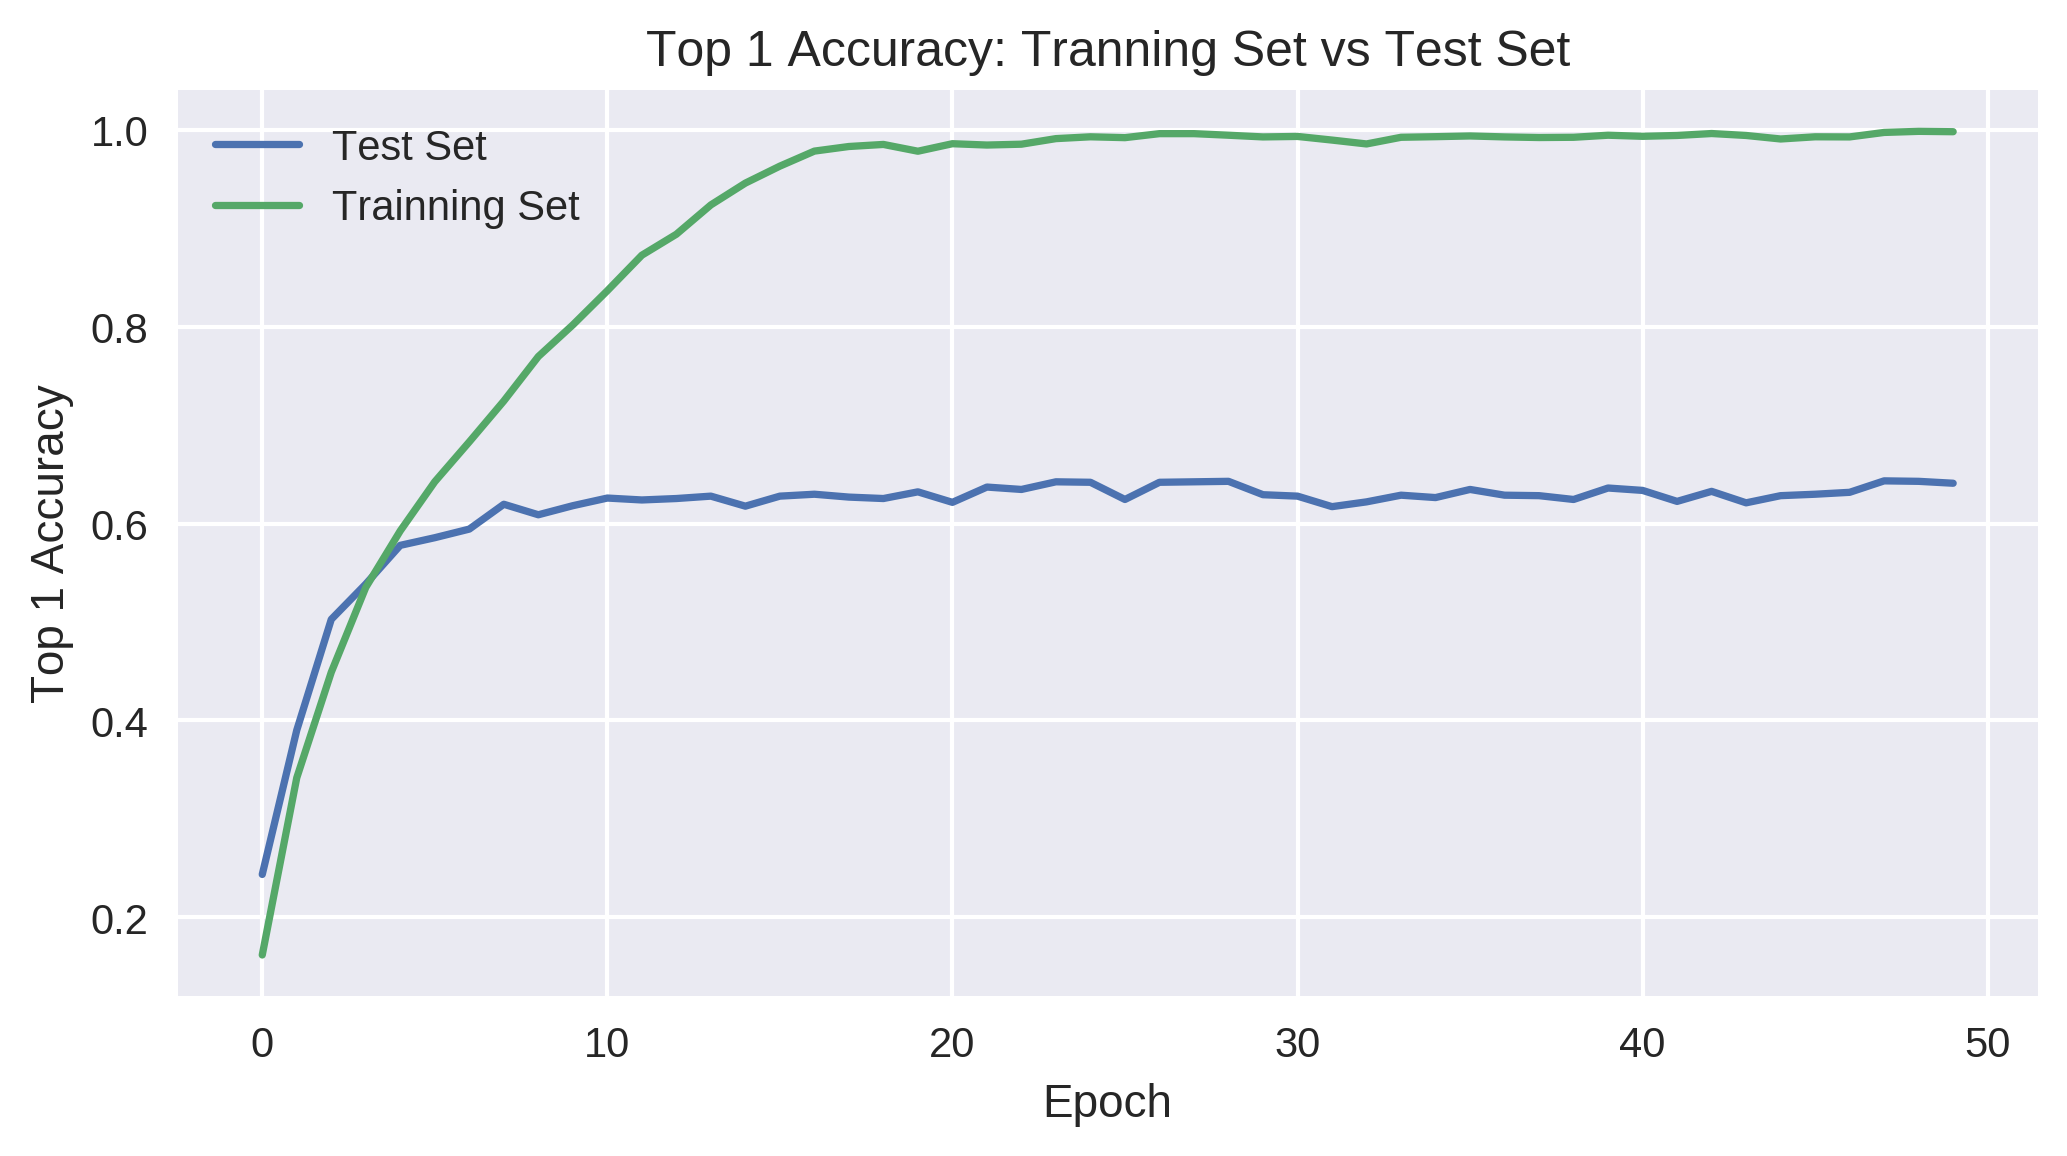

In [17]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 1 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 1 Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Test Set")
plt.plot(history.history['categorical_accuracy'], label="Trainning Set")
plt.legend()
plt.show()

### Plot Loss

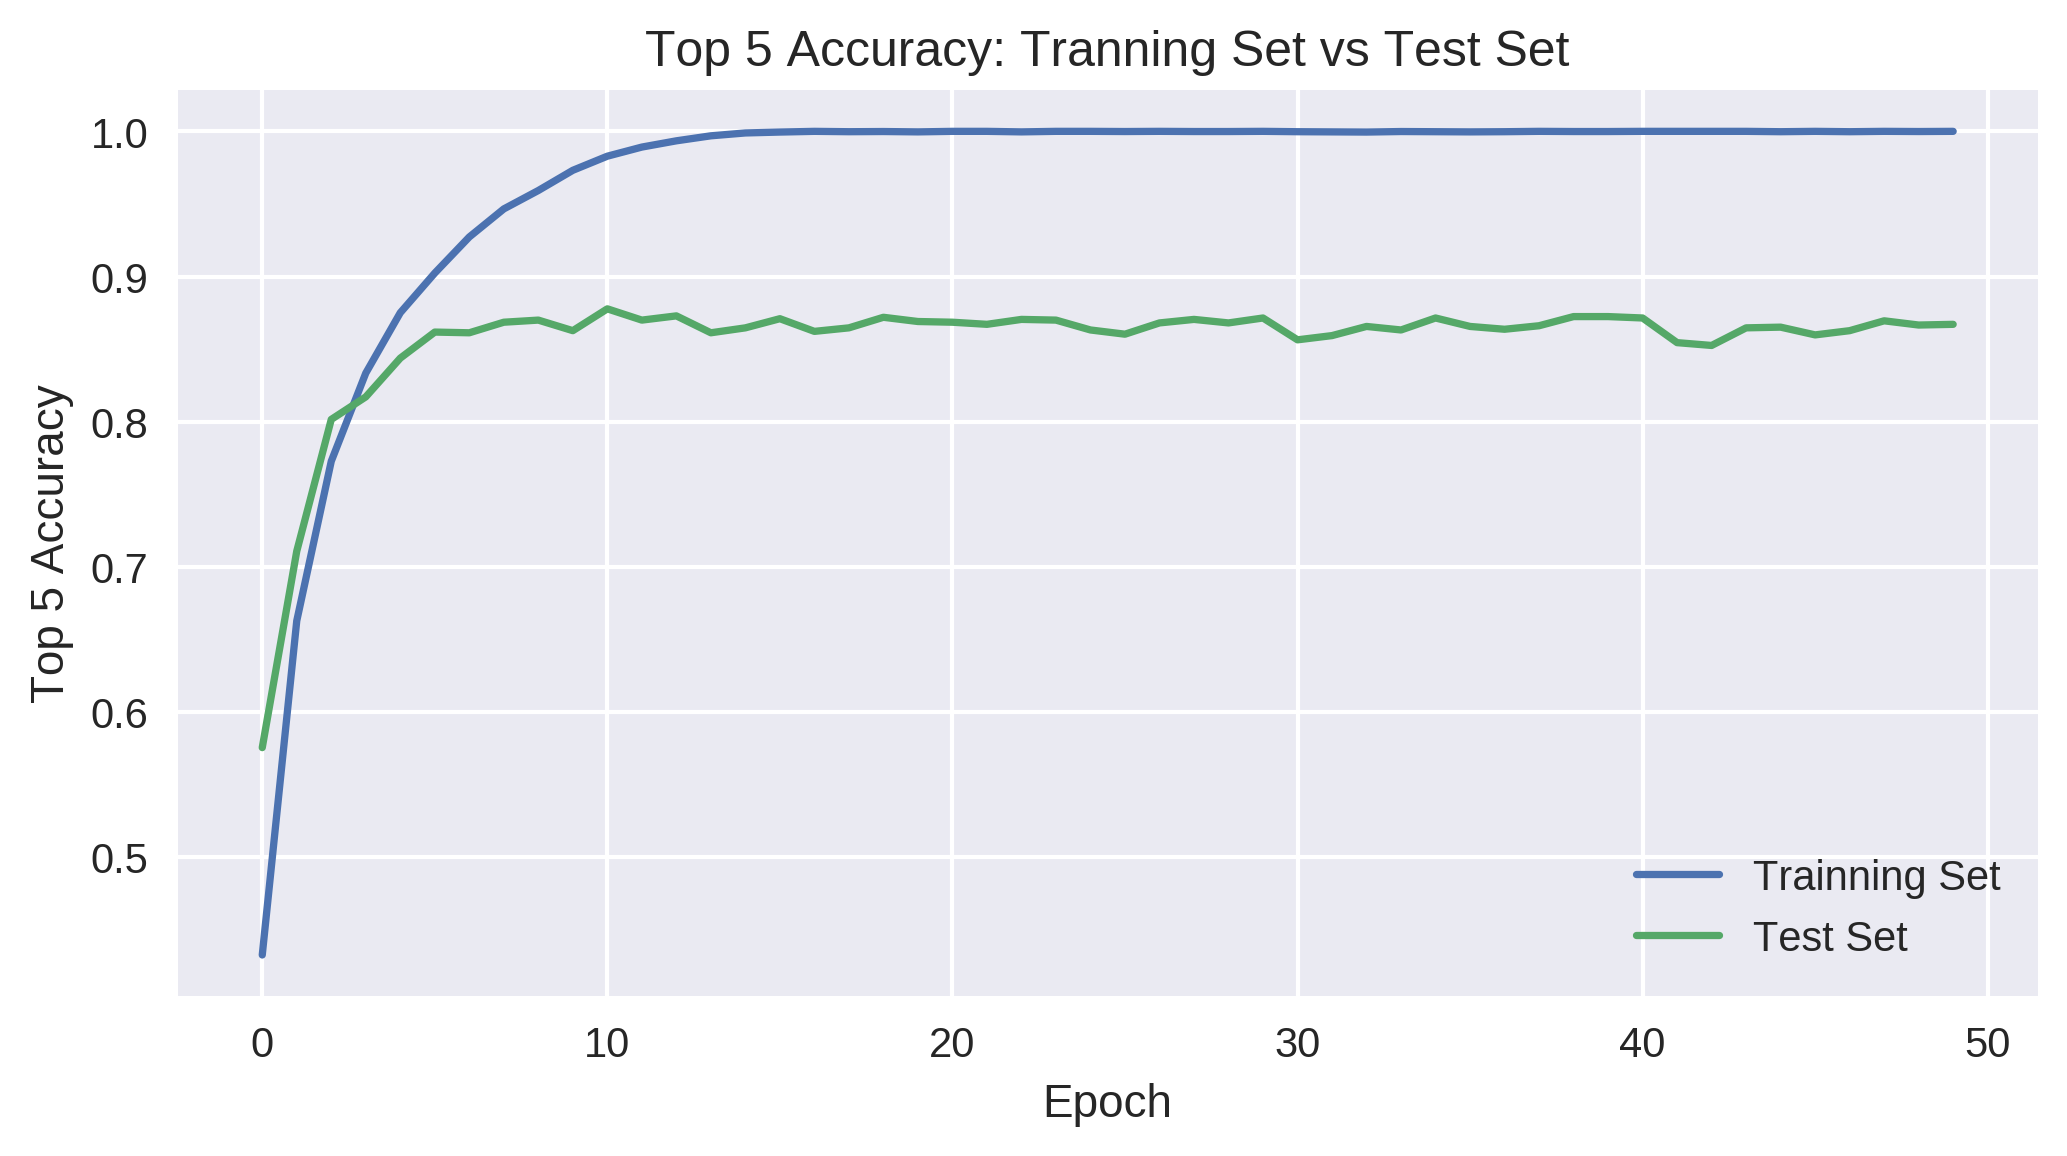

In [18]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Top 5 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 5 Accuracy")
plt.plot(history.history['top_k_categorical_accuracy'], label="Trainning Set")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Test Set")
plt.legend()
plt.show()

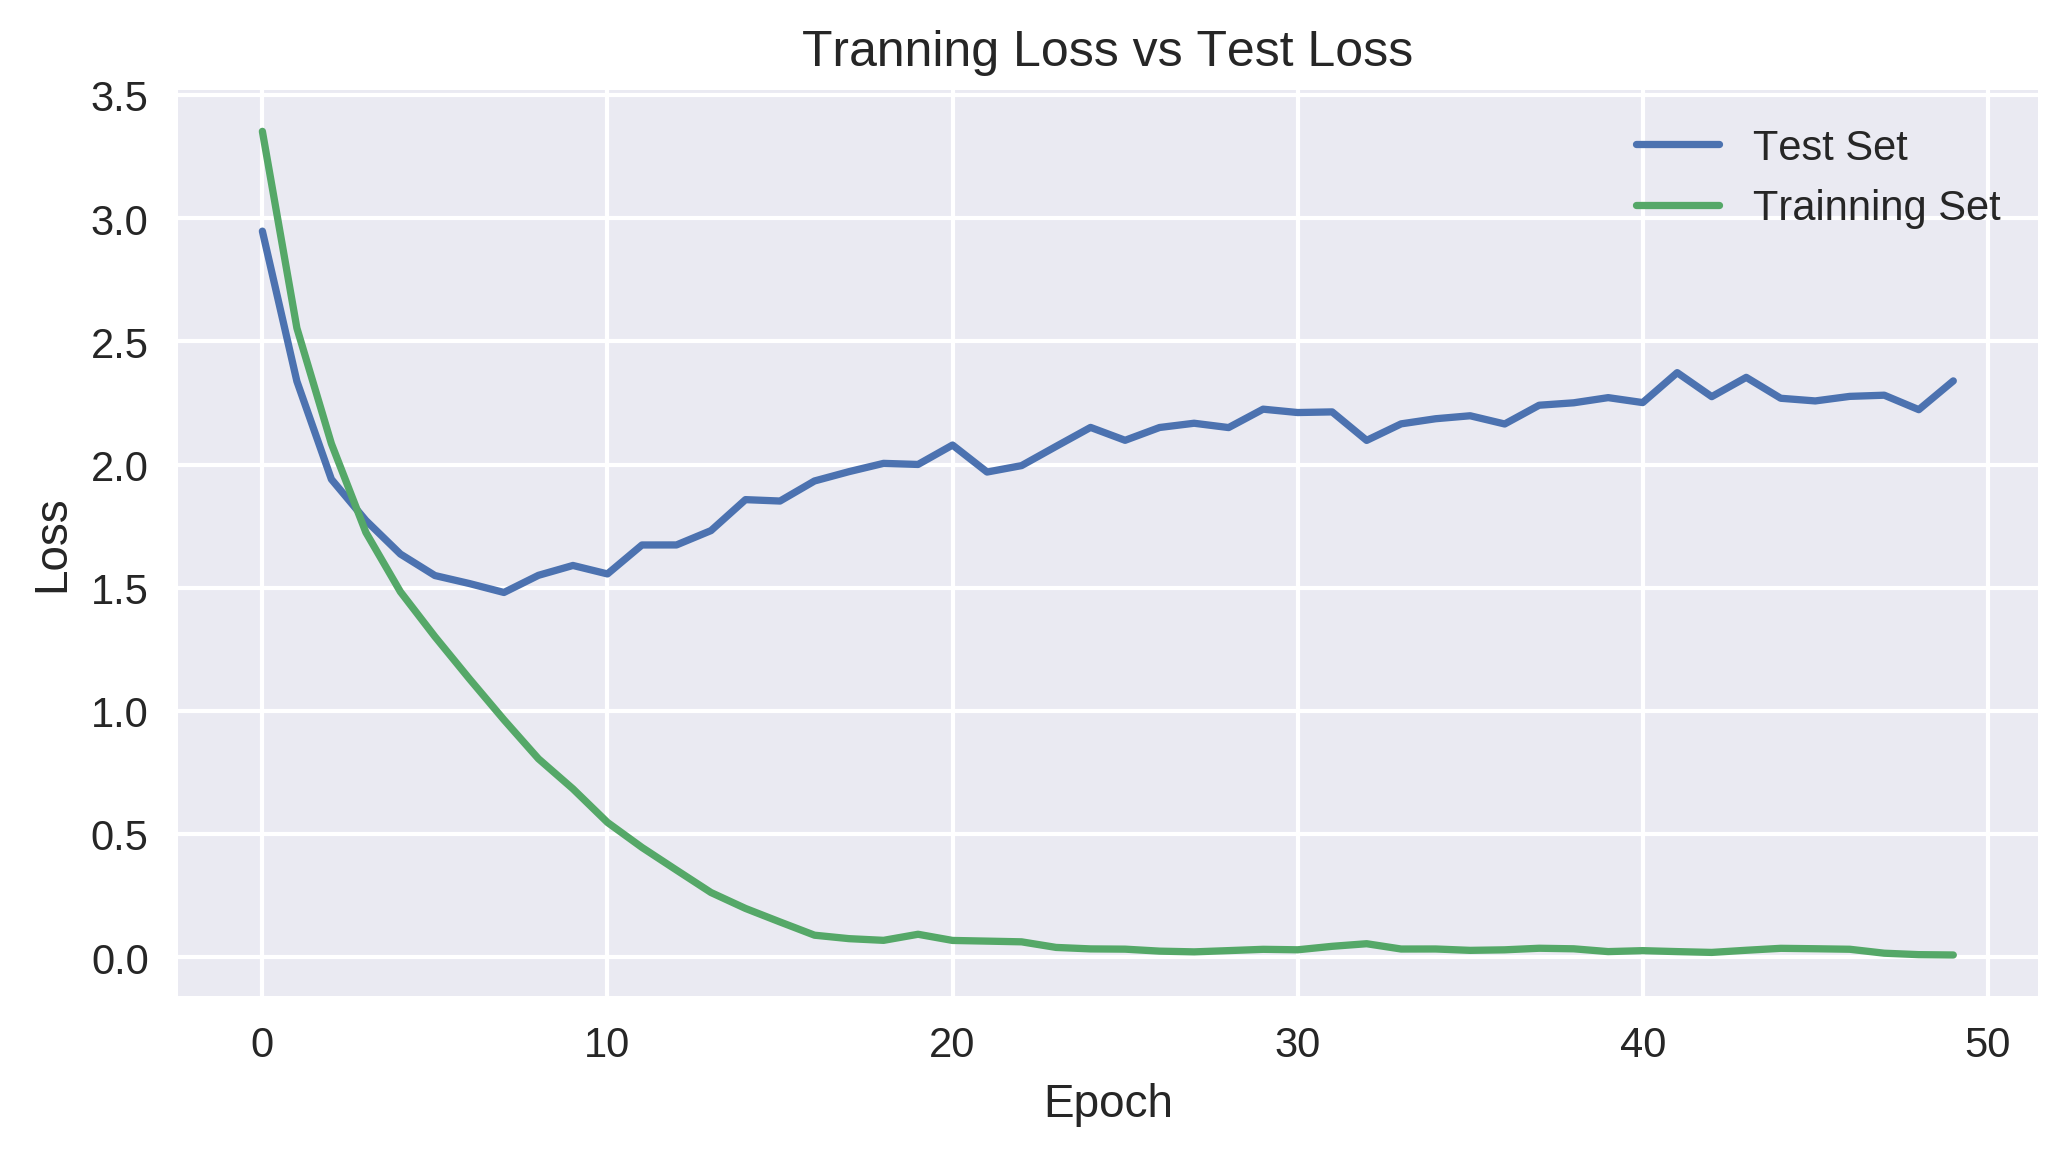

In [19]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=300)
plt.title("Tranning Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], label="Test Set")
plt.plot(history.history['loss'], label="Trainning Set")
plt.legend()
plt.show()


### Save History

In [0]:
import pickle
  
f = open('ServeNet/trainHistoryDictGlove200-1-BI-LTSM(1024)', 'wb')
pickle.dump(history.history, f)
f.close()
  

### Load History

In [0]:
f = open('ServeNet/trainHistoryDictGlove200-1-BI-LTSM(1024)', 'rb')
his = pickle.load(f)
f.close()

In [22]:
val_top_k = his['val_top_k_categorical_accuracy']
print(max(val_top_k))
print(np.argmax(val_top_k))
val_loss = his['val_loss']
print(min(val_loss))
print(np.argmin(val_loss))
val_ca = his['val_categorical_accuracy']
print(max(val_ca))
print(np.argmax(val_ca))

0.877729257699762
10
1.4805881719112628
7
0.6433770015423649
47


### Model Save

In [0]:
model.save('ServeNet/Serve_Net_Glove200_1_BI_LTSM(1024).h5') 

### Model Load

In [0]:
model = load_model('ServeNet/Serve_Net_Glove200_1_BI_LTSM(1024).h5')

In [25]:
print("Training set:")
loss_train, mae_train, top5error_train = model.evaluate(X_train, Y_train)
print("Training accuracy = ", top5error_train)
print('Test set:')
loss_test, mae_test, top5error_test = model.evaluate(X_test, Y_test)
print("Training accuracy = ", top5error_test)

Training set:
8123/8123 [==============================] - 57s 7ms/step
Training accuracy =  1.0
Test set:
2061/2061 [==============================] - 15s 7ms/step
Training accuracy =  0.8670548278113582


In [0]:
# This code allows you to see the mislabelled examples
C = 50
# y_test_oh = np.eye(C)[Y_test.reshape(-1)]
# X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
predY_test = model.predict(X_test)

In [0]:
# Heatmap Data
non_onehot_pred_test = np.argmax(predY_test, axis=1)
non_onehot_Y_test = np.argmax(Y_test, axis=1)
categories = ['Financial', 'Project Management', 'Banking', 'Backend', 'Shipping', 'File Sharing', 'Email', 'Mapping', 'Domains', 'Social', 'Weather', 'Storage', 'Tools', 'Games', 'Events', 'Security', 'Analytics', 'Travel', 'Data', 'Reference', 'Office', 'Medical', 'Photos', 'Images', 'Education', 'Cloud', 'Chat', 'Application Development', 'Database', 'Messaging', 'News Services', 'Advertising', 'eCommerce', 'Transportation', 'Government', 'Other', 'Music', 'Sports', 'Internet of Things', 'Science', 'Telephony', 'Stocks', 'Media', 'Entertainment', 'Payments', 'Real Estate', 'Bitcoin', 'Search', 'Enterprise', 'Video', 'All']

print(non_onehot_pred_test.shape)
print(non_onehot_Y_test.shape)


(2061,)
(2061,)


In [0]:
# Heat Map

# cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test.reshape(len(non_onehot_pred_test),), rownames=['Actual'], colnames=['Predicted'], margins=True)
cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test, rownames=['Actual'], colnames=['Predicted'], margins=True)  

In [0]:
cross.index = categories
cross.index.name = "Actual"
cross.columns = categories
cross.columns.name = "Predicted"
cross.head()

Predicted,Financial,Project Management,Banking,Backend,Shipping,File Sharing,Email,Mapping,Domains,Social,...,Stocks,Media,Entertainment,Payments,Real Estate,Bitcoin,Search,Enterprise,Video,All
Actual,,,,,,,,,,,,,,,,,,,,,
Financial,7,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,2,1,0,16
Project Management,0,31,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,3,1,0,41
Banking,0,1,32,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,39
Backend,0,0,0,3,1,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,16
Shipping,0,1,2,0,13,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,28


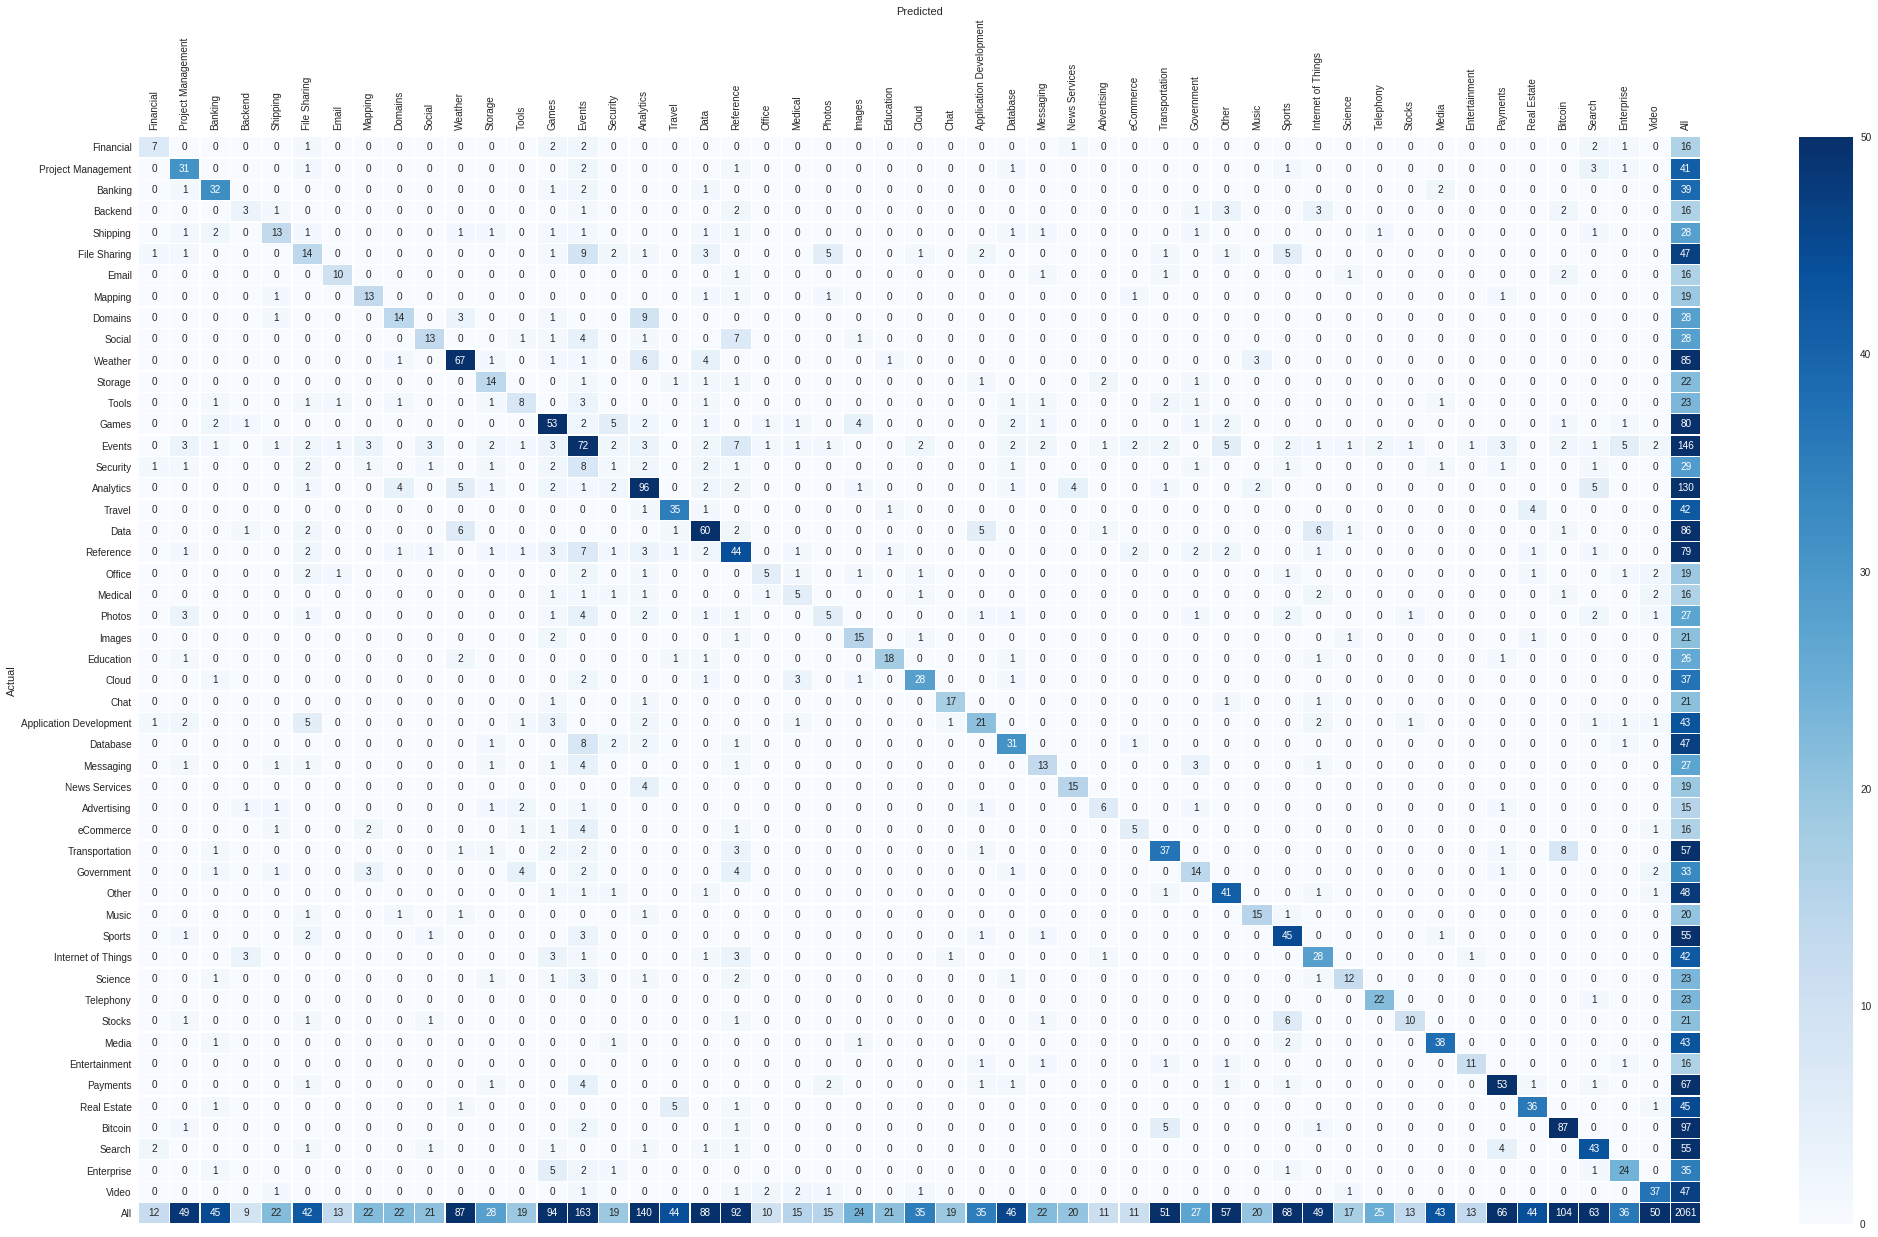

In [0]:
f, ax = plt.subplots(figsize=(35,20))

sns.heatmap(cross, annot=True, vmin=0, fmt="d", vmax=50, ax=ax, linewidths=.3, cmap=plt.cm.Blues)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

plt.savefig('ServeNet/heatmap.pdf', format='pdf', dpi=300)